In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import arviz as az
import matplotlib.cm as cm
import pytensor as pt
import pdfplumber
import xarray as xr
sns.set_style("whitegrid")

# A Bayesian analysis method for carbon cycle parameters
This notebook illustrates a proposed fully Bayesian method for incorporating CMIP model estimates and emergent constraints. As an example, we constrain the land carbon response to increasing temperatures ($\gamma_L$) using CMIP model simulations and the constraint on tropical $\gamma_L$ from internal variability proposed by Cox et al 2013 and extended to CMIP6 by Zechlau et al 2022.

## Reading in the data
In this section we explain what we mean by "evidence", which data we use, and how we process it.

### Carbon cycle parameters 
Data from three generations of CMIP models is provided by Jones and Friedlingstein https://iopscience.iop.org/article/10.1088/1748-9326/ab858a

In [4]:
online = False

In [5]:

if online:
    url = "https://docs.google.com/spreadsheets/d/14n6npj77hl-bGkNhE3wHSWS4Xt-Zd9Ww/export?format=csv&gid=99467917"
    df = pd.read_csv(url,header=9)
    #Optional: display the dataframe to make sure it loaded properly

    saveit=False
    if saveit:
        df.to_csv("DATA/OFFLINE.csv")
else:
    df=pd.read_csv("DATA/OFFLINE.csv")

display=False
if display:
    df

Split the data up by generation and read in parameters (specify whether we want land, ocean, or total).


In [6]:
def get_generations(variable_to_estimate='γL (PgC K-1)'):
    split5,split6=np.where(df["model"]=="model")[0]
    
    c4mip=df[:split5-2]
    cmip5=df[split5+1:split6-2]
    cmip6=df[split6+1:]
    
    # Dictionary of γ
    X={}
    X["C4MIP"]=c4mip[variable_to_estimate].values.astype(np.float32)
    X["CMIP5"]=cmip5[variable_to_estimate].values.astype(np.float32)
    X["CMIP6"]=cmip6[variable_to_estimate].values.astype(np.float32)
    return X

#### CMIP6
For simplicity, we'll only use CMIP6 data (ie, we'll assume the most recent generation of model data supercedes all previous generations)


In [7]:
evidence_CMIP6={}
variables_to_estimate=df.columns[4:11]
shortnames=[x.split()[0]for x in variables_to_estimate]
for lab,vari in zip(shortnames,variables_to_estimate):
    X=get_generations(vari)
    evidence_CMIP6[lab]=X["CMIP6"]


###  Emergent constraints
Read in the emergent constraint data from Zechlau et al 2022

In [8]:
with pdfplumber.open("DATA/Zechlau2022.pdf") as pdf:
    page = pdf.pages[6]
    zechtable = page.extract_table()

title=" ".join([x.split("\n") for x in zechtable[0]][0])
rawcolumns=zechtable[1][0].split(" ")
columns=["Model", "γ_LT", "σ_LT", 'γ_IAV', "σ_IAV"]
zdata=zechtable[2:][0][0].split()
ncol=len(columns)

cmip5_list = [item for item in zdata[1:zdata.index("CMIP6")] if item != '±']
L=len(cmip5_list)

nrows=int(L/ncol)
cmip5_gammas=pd.DataFrame(np.array(cmip5_list).reshape((nrows,ncol)),columns=columns)

cmip6_list = [item for item in zdata[zdata.index("CMIP6")+1:zdata.index("OBS")] if item != '±']
cmip6_list
L6=len(cmip6_list)
rows6=int(L6/ncol)
cmip6_strings=np.array(cmip6_list).reshape((rows6,ncol))
cmip6_gammas=pd.DataFrame(cmip6_strings,columns=columns)


# now need to do some more data cleaning :(
mystr=cmip6_gammas["γ_LT"].values[0]
# For some reason it can't read the minus sign from the pdf- replace by hand
badval=mystr[0]


for c in columns[1:]:
    try:
        cmip6_gammas[c]=pd.to_numeric(cmip6_gammas[c])
    except:
        
        cmip6_gammas[c]=[float(x.replace(badval,"-")) for x in cmip6_gammas[c]]

In [9]:
evidence_EC = {"γ_LT":cmip6_gammas.γ_LT.values,\
            "γ_IAV":cmip6_gammas.γ_IAV.values,\
            "σ_LT":cmip6_gammas.σ_LT.values,\
            "σ_IAV":cmip6_gammas.σ_IAV.values,\
            "IAV_observed_mean":-4.3,\
            "IAV_observed_std": 0.67 }

# From Thorsten: Evidence for TCR

In [10]:
f2x = 3.93 # AR6
year_1_start = 1850
year_1_end   = 1900
year_2_start = 2005
year_2_end   = 2024
nyears       = 2024-1850+1
forcing = pd.read_csv('/Users/kmarvel/Documents/tcr4tcre/forcing_data/ERF_ssp245_1750-2500.csv')

forcing_id1 = np.squeeze(np.where((forcing['year'] >= year_1_start) & (forcing['year'] <= year_1_end)))
forcing_id2 = np.squeeze(np.where((forcing['year'] >= year_2_start) & (forcing['year'] <= year_2_end)))

delta_forcing = np.mean(forcing['total'][forcing_id2]) - np.mean(forcing['total'][forcing_id1])
def read_temperature_dataset(case_id):
    
    hadcrut  = xr.open_dataset('/Users/kmarvel/Documents/tcr4tcre/temperature_data/HadCRUT.5.0.2.0.analysis.anomalies.ensemble_mean_fldmean.nc').mean(dim=["lat", "lon"])
    noaa     = xr.open_dataset('/Users/kmarvel/Documents/tcr4tcre/temperature_data/NOAAGlobalTemp_v6.0.0_gridded_s185001_e202506_c20250707T122952_fldemean.nc').mean(dim=["lat", "lon", "z"])
    temp     = np.loadtxt('/Users/kmarvel/Documents/tcr4tcre/temperature_data/Berkeley_Earth_Land_and_Ocean_summary.txt', skiprows=58, usecols =(0,1))
    berkeley = xr.Dataset(
                {"tas_mean": ("time", temp[:, 1])},
                coords={"time": temp[:, 0].astype(int)}
                )

    if   case_id == 0:
        n = 3
        temperature = hadcrut # just to get the structure
        temperature['tas_mean'].values =  1.0/n*(hadcrut['tas_mean'].values + noaa['tas_mean'].values + berkeley['tas_mean'].values)
    elif case_id == 1:
        temperature = hadcrut
    elif case_id == 2:
        temperature = noaa
    elif case_id == 3:
        temperature = berkeley
    else:
        raise ValueError(f"Unknown data ID: {case_id}. Please provide a valid ID.")

    pre_industrial_temperature = np.mean(temperature.sel(time=slice(str(1850), str(1900)))['tas_mean'].values)
    temperature['tas_mean'][:] = temperature['tas_mean'][:] - pre_industrial_temperature
    
    return temperature
temperature = read_temperature_dataset(0)

temperature_1 = temperature['tas_mean'].sel(time=slice(str(year_1_start), str(year_1_end)))
temperature_2 = temperature['tas_mean'].sel(time=slice(str(year_2_start), str(year_2_end)))

delta_temperature = temperature_2.mean(dim=["time"]).values-temperature_1.mean(dim=["time"]).values

sigma_dT   = (1.18-0.86)/2/1.645 #AR6
sigma_dF   = (3.48-1.96)/2/1.645 #AR6
sigma_dF2x = 0.1*f2x/1.645       #AR6 

# Estimate using process-level understanding:

# Feedback parameter assessed from process-levle understanding in AR6:

lambda_mean  = -1.16
lambda_sigma = (1.81-0.51)/2/1.645 

# We use AR6 chapter 7.5.1.2, combining ocean heat uptake parameter (gamma) 
# and pattern effect (epsilon) into a single parameter (kappa = epsilon*gamma):

kappa_mean  = 0.84
kappa_sigma = 0.38/1.645

evidence_TCR = {"F2X":f2x,
                "σ_F2x":sigma_dF2x,\
                "ΔT":delta_temperature,\
                "σ_ΔT":sigma_dT,\
                "ΔF":delta_forcing,\
                "σ_ΔF":sigma_dF,\
                "λ_mean":lambda_mean,
                "λ_sigma":lambda_sigma,
                "κ_mean":kappa_mean,
                "κ_sigma":kappa_sigma}

In [12]:
evidence = evidence_CMIP6 | evidence_EC | evidence_TCR

### Scaling factors
From Chris Jones, personal communication.  The scaling factor $\eta$ is applied to $\beta$ to represent the impact of including a full nitrogen cycle on the CO$_2$ fertilization effect.  A scaling factor $\nu$ is applied to $\gamma$ to represent the N cycle impact on the climate-carbon feedback.  Two modeling groups (ACCESS and UKESM) have performed process-based simulations to calculate $\eta$ and $\nu$.


In [16]:
# from Chris: 
eta_access= 0.69 
eta_ukesm=0.77

# from Chris
nu_access=0.70 
nu_ukesm=0.95


evidence["ν"] = [nu_access,nu_ukesm]
evidence["η"] = [eta_access,eta_ukesm]

Now split up the models: some have a nitrogen cycle, while some don't.

In [17]:
split5,split6=np.where(df["model"]=="model")[0]
cmip6=df[split6+1:]

hasN=cmip6[cmip6.columns[3]].values.astype(int).astype(bool)
#Models with N-cycle
print("******* Has N cycle *******")
tmp=[print(x) for x in cmip6[hasN].model.values ]
# Models with no N cycle
print("******* Doesn't have N cycle *******")
tmp=[print(x) for x in cmip6[~hasN].model.values ]

******* Has N cycle *******
ACCESS-ESM1.5
CESM2
MIROC-ES2L
MPI-ESM1.2-LR
NorESM2-LM
UKESM1-0-LL
******* Doesn't have N cycle *******
BCC-CSM2-MR
CanESM5
CNRM-ESM2-1
IPSL-CM6A-LR
NOAA-GFDL-ESM4


#### Sanity check
Models with a nitrogen cycle have lower CO2 fertilization than models without due to N limitations

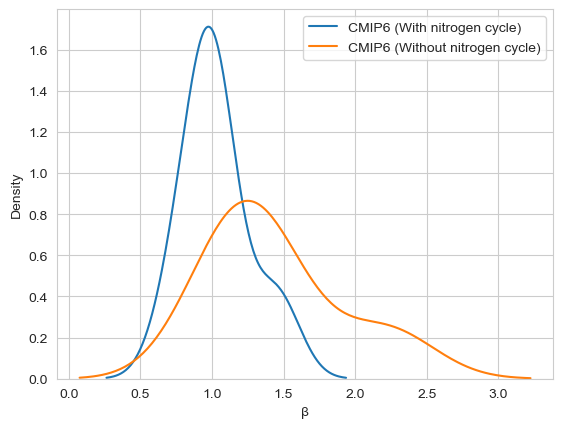

In [18]:
beta_including_N=evidence['βL'][hasN]
beta_without_N=evidence['βL'][~hasN]

sns.kdeplot(beta_including_N,label="CMIP6 (With nitrogen cycle)")
sns.kdeplot(beta_without_N,label="CMIP6 (Without nitrogen cycle)")
tmp=plt.legend()
tmp=plt.xlabel("β")

evidence["βL_including_N"]=beta_including_N
evidence["βL_without_N"]=beta_without_N

 Models with a nitrogen cycle have a more constrained (and less negative) climate-carbon feedback  because warming of the soil increases
nitrogen availability, as well as accelerating the decomposition of organic matter (Zechlau et al 2022)

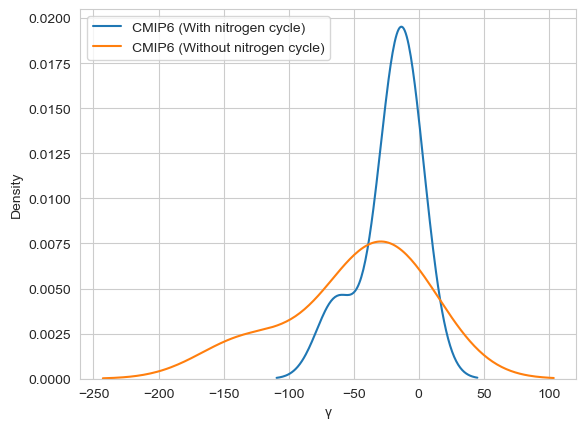

In [20]:
gamma=evidence['γL']
gamma_including_N=gamma[hasN]
gamma_without_N=gamma[~hasN]

sns.kdeplot(gamma_including_N,label="CMIP6 (With nitrogen cycle)")
sns.kdeplot(gamma_without_N,label="CMIP6 (Without nitrogen cycle)")
tmp=plt.legend()
tmp=plt.xlabel("γ")

evidence["γL_including_N"]=gamma_including_N
evidence["γL_without_N"]=gamma_without_N

## Random-effects model for combining CMIP6 data
We assume that each model gives us a $x^i$ that differs from the ``true" $X$ by some bias:
$$x^i \sim N(X-B_i,\sigma_i^2)$$
with the biases distributed as 
$$B_i \sim N(0,\tau^2)$$
If we don't care about the posteriors for each individual bias term $B_i$ we can marginalize over them:
$$P(x_i | X) = \int P(x_i | X,B_i) P(B_i) dB_i.$$
Since everything is Gaussian the integral has an analytic solution and 
$$x^i \sim N(X,\sigma_i^2+\tau^2)$$
# TO DO: REPLACE SIGMA WITH CMIP6 VALUES

In [23]:
def build_betaO_model(evidence, priors, hyperpriors):
    βO=priors["βO"](name="βO")
    # Noise in each CMIP6 model due to internal variability
    # Right now I'm assuming each model's internal variability is on order the whole model spread
    sigma=np.std(evidence["βO"]) # REPLACE WITH ACTUAL CMIP6 VALUES WHEN I GET THEM
    #sigma=pm.HalfNormal("sigma",5)
    tau=hyperpriors["τ_βO"](name="τ_βO")#pm.HalfNormal("tau",5)
    pm.Normal("lik",mu=βO,sigma=pm.math.sqrt(sigma**2+tau**2),observed = evidence["βO"])
    return {
        "βO": βO,
        "τ_βO": τ_βO 
    }

# Estimating $\gamma_O$
Let's use the same random effects model to estimate the ocean climate effect $\gamma_O$

In [24]:
def build_gammaO_model(evidence, priors, hyperpriors):
    γO=priors["γO"](name="γO")
    # Noise in each CMIP6 model due to internal variability
    # Right now I'm assuming each model's internal variability is on order the whole model spread
    sigma=np.std(evidence["γO"]) # REPLACE WITH ACTUAL CMIP6 VALUES WHEN I GET THEM
    #sigma=pm.HalfNormal("sigma",5)
    tau=hyperpriors["τ_γO"](name="τ_γO")
    lik=pm.Normal("lik",mu=γO,sigma=pm.math.sqrt(sigma**2+tau**2),observed = evidence["γO"])
    return {
        "γO": γO,
        "τ_γO": τ_γO 
    }

# Estimating $\beta_L$
## Inclusion of processes
Some CMIP6 models have explicit representation of processes that affect $\beta$ and $\gamma$ while others do not.  For example, roughly half the CMIP6 models represent the N cycle.  

We want to get information about $\beta$ from all the models- we don't just want to throw away the results from the models without a nitrogen cycle!  This means we need a model for how including the N cycle might modify the estimate of $\beta$.  Let's try a multiplicative model, where including this process modifies the total: $\beta = \eta b$.

Every result from the CMIP6 models tells us about $b$, but only the models with nitrogen cycles can tell us about $\eta$.  I assume there's an intrinsic CMIP model spread (estimated from all models) in $b$ (denoted $\sigma_b$) and a model spread in the scaling factor $\sigma_{\eta}$ (estimated only from the models with a nitrogen cycle.). The standard deviation of the product $\eta b$ is assumed to be $\sigma_{\eta b} = \sqrt{\bar{\eta}^2 \sigma_{b}^2 + \bar{b}^2 \sigma_{\eta}^2 + \sigma_{\eta}^2 \sigma_{b}^2}$


In [433]:
# USE THIS ONE

#sigma_eta_obs =  0.1  # observational uncertainty for eta


with pm.Model() as beta_land_model:
    
    # η prior, informed by observations
    #PRIOR
    eta = pm.Uniform("eta", 0,1)
    # Variance of eta
    #PRIOR
    sigma_eta = pm.HalfNormal("sigma_eta",0.1)  
    # Learn the true value of η and its uncertainty from the published estimates 
    eta_obs=pm.Normal("eta_obs", mu=eta, sigma=sigma_eta, observed=evidence["η"])

    
    # mean of unscaled CO2 effect 
    #PRIOR
    #IT WILL BE SENSITIVE TO THIS
    βL=pm.Normal("βL",0,100)

    # Structural spread of models with no nitrogen cycle
    #PRIOR
    tau_B = pm.HalfNormal("tau_B", sigma=0.05)
    
   
    mu_B = pm.Deterministic("mu_B", βL/eta)

    
    # Derived standard deviation for β models
    tau_beta_sq =  eta**2 * tau_B**2 + mu_B**2 * sigma_eta**2
    tau_beta = pm.Deterministic("tau_beta", pm.math.sqrt(tau_beta_sq))
    
    #Internal variability: REPLACE IF WE GET MODEL ESTIMATES
    #IT'S VERY SENSITIVE TO THIS
    sigma_b=.1 #np.sqrt(evidence['βL_without_N'])
    sigma_beta = .1  #np.sqrt(evidence['βL_including_N'])
    
    # Likelihoods
    B_obs = pm.Normal("B_obs", mu=mu_B, sigma=pm.math.sqrt(tau_B**2+sigma_b**2), observed=evidence['βL_without_N'])
    beta_obs = pm.Normal("beta_obs", mu=βL, sigma=pm.math.sqrt(tau_beta**2+sigma_beta**2), observed=evidence['βL_including_N'])

    # Posterior sampling
    beta_land_trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, sigma_eta, βL, tau_B]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


<Axes: title={'center': 'βL'}>

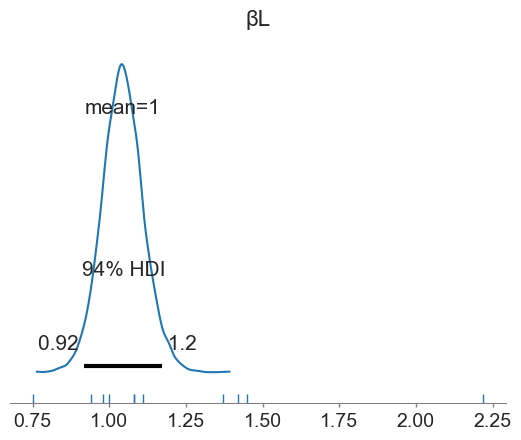

In [434]:
az.plot_posterior(beta_land_trace,var_names=["βL"])
sns.rugplot(evidence["βL"])


# Estimating $\gamma_L$ 
We assume that the nitrogen cycle scaling parameter is $\nu$
## Modeling the emergent constraint
We model IAV as linear in $\gamma_L$: 
$$IAV = m \gamma_L + b + \epsilon$$
where $\epsilon \sim N(0,\sigma)$ is the noise.  In Bayesian linear regression, this is expressed as a conditional distribution:
$$ IAV | \gamma_L \sim N(m \gamma_L+b,\sigma)$$
There are three hyperparameters: the slope of the line $m$, the intercept $b$, and the noise $\sigma$.  Note that the choice of model for the emergent constraint (here it's linear) determines the parameters $\Theta = (m,b,\sigma)$.  We'll use priors $m,b \sim N(0,10)$ and $\sigma \sim N^{+}(10)$.  You could allow users to specify these priors -- this would probably make sense for cases in which the relationship between the observable quantity and the thing to be esimated is less clear-- but here the functional form is pretty obviously linear and it won't really matter which priors we use.

In [300]:
# Note that we put priors on negative gamma so gamma can be made negative definite if desired
priors = {
    'neg_gamma_LT': lambda name: pm.Normal(name,0,100),#lambda name: pm.LogNormal(name, mu=np.log(50), sigma=1),
    'nu': lambda name: pm.Uniform(name, 0,1),\
    'neg_gamma_LX': lambda name: pm.Normal(name,0,100)
    
}

hyperpriors={
        'm': lambda name: pm.Normal(name,0,10),
        'b': lambda name: pm.Normal(name,0,10),
        'sigma_nu' : lambda name: pm.HalfNormal(name,0.1) ,\
        'tau_G' : lambda name: pm.HalfNormal(name, sigma=np.std(evidence["γL"]))
    
}

In [301]:

with pm.Model() as random_effects_model_gamma:

    # Variance of nu
    #HYPERPRIOR
    sigma_nu = hyperpriors["sigma_nu"](name="sigma_nu") 
    # nu prior, informed by observations
    #PRIOR on scaling from nitrogen inclusion
    nu = priors["nu"](name="nu")
    # Learn the true value of nu and its uncertainty from the published estimates 
    nu_obs=pm.Normal("nu_obs", mu=nu, sigma=sigma_nu, observed=evidence["ν"])
    
    # PRIORS ON TROPICAL AND EXTRATROPICAL GAMMA
    γLX = pm.Deterministic("γLX",priors["neg_gamma_LX"](name='neg_gamma_LX')*-1)
    γLT = pm.Deterministic("γLT",priors["neg_gamma_LT"](name='neg_gamma_LT')*-1)
    γL= pm.Deterministic("γL",γLX + γLT)

    #IF WE WANT TO WE CAN ADD A GAMMA_PERMAFROST TERM HERE
    # DO WE HAVE ANY EVIDENCE?


    ### EMERGENT CONSTRAINT ###
    # EMERGENT CONSTRAINT ON TROPICAL γLT
    n_models_EC=len(evidence['γ_LT'])
        #Assume linear relationships
    m = hyperpriors["m"](name="m")
    b = hyperpriors["b"](name="b")

    # Latent true x values
    x_true = pm.Normal("x_true", mu=evidence['γ_LT'], \
                       sigma=evidence['σ_LT'], \
                       shape=n_models_EC)

    # Linear model for true IAV values
    y_true = m * x_true + b

    # Likelihood of observed IAV values
    y_likelihood = pm.Normal("y_obs", mu=y_true, \
                             sigma=evidence['σ_IAV'],\
                             shape=n_models_EC,\
                             observed=evidence['γ_IAV'])
    #Emergent constraint relationship
   
    mu_obs = m * γLT + b
    # IAV observed ~ N(-4.3,0.67) #CHECK IF THIS IS ONE OR TWO SIGMA
    IAV_true=pm.Normal("IAV_true",mu=mu_obs,\
                       sigma=evidence["IAV_observed_std"],\
                       observed = [evidence["IAV_observed_mean"]])
    

    # UNSCALED VALUE
    mu_G = γL/nu

    # Structural spread of models with no nitrogen cycle
    #HYPERPRIOR
    tau_G = hyperpriors["tau_G"](name="tau_G")
    
    

    
    # Derived standard deviation for  models
    tau_gamma_sq =  nu**2 * tau_G**2 + mu_G**2 * sigma_nu**2
    tau_gamma = pm.Deterministic("tau_gamma", pm.math.sqrt(tau_gamma_sq))

    # internal variability terms
    #REPLACE WITH MODEL-BASED ESTIMATES
    sigma_gamma=.1
    sigma_G = .1
    
    
    
    # Likelihoods
    G_obs = pm.Normal("G_obs", mu=mu_G, sigma=pm.math.sqrt(tau_G**2+sigma_G**2), observed=evidence['γL_without_N'])
    gamma_obs = pm.Normal("gamma_obs", mu=γL, sigma=pm.math.sqrt(tau_gamma**2+sigma_gamma**2), observed=evidence['γL_including_N'])

    # Posterior sampling
    random_effects_trace_gamma = pm.sample(target_accept=0.99)



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_nu, nu, neg_gamma_LX, neg_gamma_LT, m, b, x_true, tau_G]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [ ]:
with random_effects_model_gamma:
    ppd=pm.sample_posterior_predictive(random_effects_trace_gamma)

In [474]:
def stackit(X):
    return X.stack(samples=("chain","draw"))

In [479]:
testdict={"x":stackit(random_effects_trace_gamma.posterior.x_true).values,\
         "y":stackit(ppd.posterior_predictive.y_obs).values}

In [488]:
x_samples=testdict["x"]
y_samples=testdict["y"]

Text(0.5, 1.0, '2D Posterior Predictive Density with Uncertainty in X and Y')

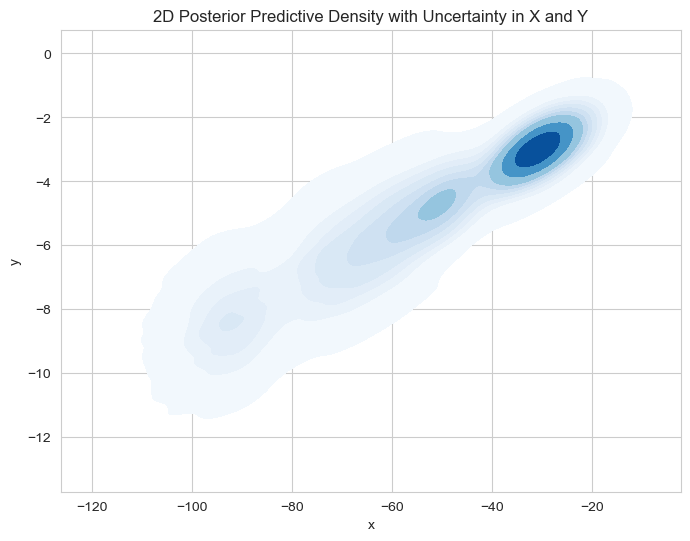

In [531]:
x_flat = x_samples.flatten()
y_flat = y_samples.flatten()

# Optional: create a DataFrame for Seaborn
df = pd.DataFrame({
    "x": x_flat,
    "y": y_flat
})

# 2D KDE plot with HDI-like contours
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df, x="x", y="y", fill=True, cmap="Blues", levels=10, thresh=0.01)
plt.title("2D Posterior Predictive Density with Uncertainty in X and Y")
#az.plot_hdi(evidence["γ_LT"],ppd.posterior_predictive.y_obs,color=cm.Reds(.9),smooth=True)

/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_72757/598491300.py:4: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  [plt.scatter(x_samples[i],y_samples[i],c=cm.Blues(i/7)) for i in range(7)]


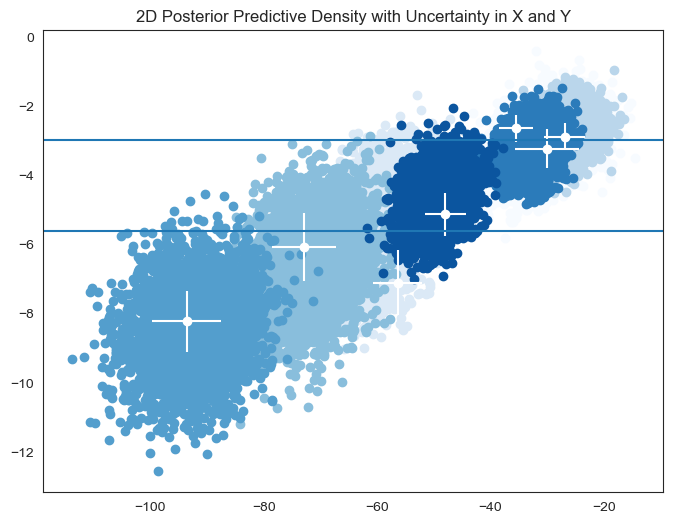

In [509]:
# 2D KDE plot with HDI-like contours
plt.figure(figsize=(8, 6))
#sns.lineplot(data=df, x="x", y="y")
[plt.scatter(x_samples[i],y_samples[i],c=cm.Blues(i/7)) for i in range(7)]
plt.title("2D Posterior Predictive Density with Uncertainty in X and Y")
#az.plot_hdi(evidence["γ_LT"],ppd.posterior_predictive.y_obs,color=cm.Reds(.9),smooth=True)
plt.errorbar(evidence["γ_LT"],evidence["γ_IAV"],xerr=evidence["σ_LT"],yerr=evidence["σ_IAV"],marker="o", linestyle='none',color="w")
plt.axhline(evidence['IAV_observed_mean']-1.96*evidence['IAV_observed_std'])
plt.axhline(evidence['IAV_observed_mean']+1.96*evidence['IAV_observed_std'])
#,evidence['IAV_observed_mean']+1.96*evidence['IAV_observed_std'],evidence["γ_LT"])

# ESTIMATING $\alpha$
TCR estimates/data come from Thorsten.  I'm combining two lines of evidence: the energy balance constraint and process-based constraints on $\lambda$ and $\kappa$.

In [515]:
f2x = 3.93 # AR6
year_1_start = 1850
year_1_end   = 1900
year_2_start = 2005
year_2_end   = 2024
nyears       = 2024-1850+1

In [516]:
forcing = pd.read_csv('/Users/kmarvel/Documents/tcr4tcre/forcing_data/ERF_ssp245_1750-2500.csv')

forcing_id1 = np.squeeze(np.where((forcing['year'] >= year_1_start) & (forcing['year'] <= year_1_end)))
forcing_id2 = np.squeeze(np.where((forcing['year'] >= year_2_start) & (forcing['year'] <= year_2_end)))

delta_forcing = np.mean(forcing['total'][forcing_id2]) - np.mean(forcing['total'][forcing_id1])

print('Change in forcing: '+str(round(delta_forcing,2))+' Wm-2')

Change in forcing: 2.3 Wm-2


In [ ]:
# Function to read different temperature datasets, 
# option 0 is the average

# IPCC AR6 used four datasets that met all necessary criteria. 
# Unfortunately, one of these datasets are not updated, Kadow 
# et al. (2020), so not included here. This dataset is similar 
# to HadCRUT5, however, which is close to the mean.

def read_temperature_dataset(case_id):
    
    hadcrut  = xr.open_dataset('/Users/kmarvel/Documents/tcr4tcre/temperature_data/HadCRUT.5.0.2.0.analysis.anomalies.ensemble_mean_fldmean.nc').mean(dim=["lat", "lon"])
    noaa     = xr.open_dataset('/Users/kmarvel/Documents/tcr4tcre/temperature_data/NOAAGlobalTemp_v6.0.0_gridded_s185001_e202506_c20250707T122952_fldemean.nc').mean(dim=["lat", "lon", "z"])
    temp     = np.loadtxt('/Users/kmarvel/Documents/tcr4tcre/temperature_data/Berkeley_Earth_Land_and_Ocean_summary.txt', skiprows=58, usecols =(0,1))
    berkeley = xr.Dataset(
                {"tas_mean": ("time", temp[:, 1])},
                coords={"time": temp[:, 0].astype(int)}
                )

    if   case_id == 0:
        n = 3
        temperature = hadcrut # just to get the structure
        temperature['tas_mean'].values =  1.0/n*(hadcrut['tas_mean'].values + noaa['tas_mean'].values + berkeley['tas_mean'].values)
    elif case_id == 1:
        temperature = hadcrut
    elif case_id == 2:
        temperature = noaa
    elif case_id == 3:
        temperature = berkeley
    else:
        raise ValueError(f"Unknown data ID: {case_id}. Please provide a valid ID.")

    pre_industrial_temperature = np.mean(temperature.sel(time=slice(str(1850), str(1900)))['tas_mean'].values)
    temperature['tas_mean'][:] = temperature['tas_mean'][:] - pre_industrial_temperature
    
    return temperature

In [518]:
temperature = read_temperature_dataset(0)

temperature_1 = temperature['tas_mean'].sel(time=slice(str(year_1_start), str(year_1_end)))
temperature_2 = temperature['tas_mean'].sel(time=slice(str(year_2_start), str(year_2_end)))

delta_temperature = temperature_2.mean(dim=["time"]).values-temperature_1.mean(dim=["time"]).values

print('Change in temperature: '+str(round(delta_temperature,2))+' K')

Change in temperature: 1.09 K


In [517]:
sigma_dT   = (1.18-0.86)/2/1.645 #AR6
sigma_dF   = (3.48-1.96)/2/1.645 #AR6
sigma_dF2x = 0.1*f2x/1.645       #AR6 

In [522]:
# Estimate using process-level understanding:

# Feedback parameter assessed from process-levle understanding in AR6:

lambda_mean  = -1.16
lambda_sigma = (1.81-0.51)/2/1.645 

# We use AR6 chapter 7.5.1.2, combining ocean heat uptake parameter (gamma) 
# and pattern effect (epsilon) into a single parameter (kappa = epsilon*gamma):

kappa_mean  = 0.84
kappa_sigma = 0.38/1.645


In [529]:
with pm.Model() as tcr_combined_model:

    # Priors for uncertain quantities
    F_2x = pm.Normal("F_2x", mu=f2x, sigma=sigma_dF2x)
    F_hist = pm.Normal("F_hist", mu=delta_forcing, sigma=sigma_dF)
    delta_T_hist = pm.Normal("delta_T_hist", mu=delta_temperature, sigma=sigma_dT)

    # Feedback/OHU parameters
    lambda_clim = pm.Normal("lambda", mu=lambda_mean, sigma=lambda_sigma)   # W/m²/°C
    kappa = pm.Normal("kappa", mu=kappa_mean, sigma=kappa_sigma)           # W/m²/°C

   # Latent TCR
    TCR = pm.Normal("TCR", mu=2, sigma=2)  # wide prior

    # Equation A: Energy balance model
    TCR_from_balance = (F_2x / F_hist) * delta_T_hist
    pm.Normal("balance_constraint", mu=TCR - TCR_from_balance, sigma=0.1, observed=0)

    # Equation B: Feedback parameter model
    TCR_from_feedback = -F_2x / (lambda_clim - kappa)
    pm.Normal("feedback_constraint", mu=TCR - TCR_from_feedback, sigma=0.1, observed=0)
    tcrtrace=pm.sample(target_accept=.99)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [F_2x, F_hist, delta_T_hist, lambda, kappa, TCR]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


<Axes: title={'center': 'TCR'}>

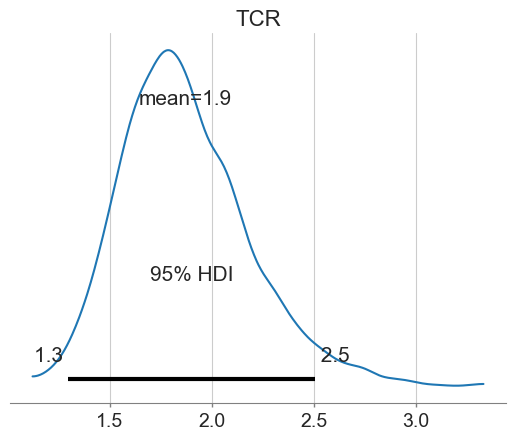

In [530]:
az.plot_posterior(tcrtrace,var_names=["TCR"],hdi_prob=.95)